In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
import time
from sklearn.datasets import fetch_20newsgroups
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from tqdm.auto import tqdm
tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Dataset Exploration

The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. 

The data is organized into 20 different newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related to each other (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are highly unrelated (e.g misc.forsale / soc.religion.christian). 

> The `sklearn.datasets.fetch_20newsgroups` function is a data fetching / caching functions that downloads the data archive from the original 20 newsgroups website, extracts the archive contents in the `~/scikit_learn_data/20news_home` folder and calls the `sklearn.datasets.load_files` on either the training or testing set folder, or both of them

In [2]:
dataset = fetch_20newsgroups(subset='all')

X = pd.Series(dataset['data'])
y = pd.Series(dataset['target'])

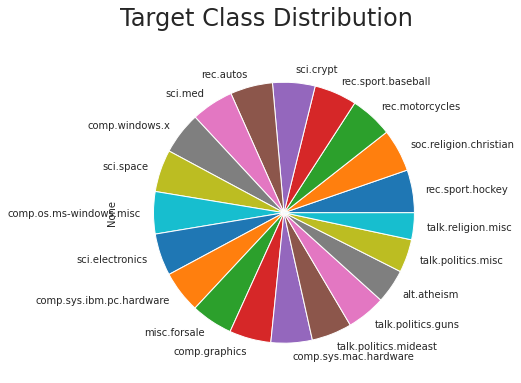

In [3]:
fig, ax = plt.subplots(figsize=(20, 6))
fig.suptitle('Target Class Distribution', fontsize=24)
y.apply(lambda i: dataset['target_names'][i]).value_counts().plot.pie()

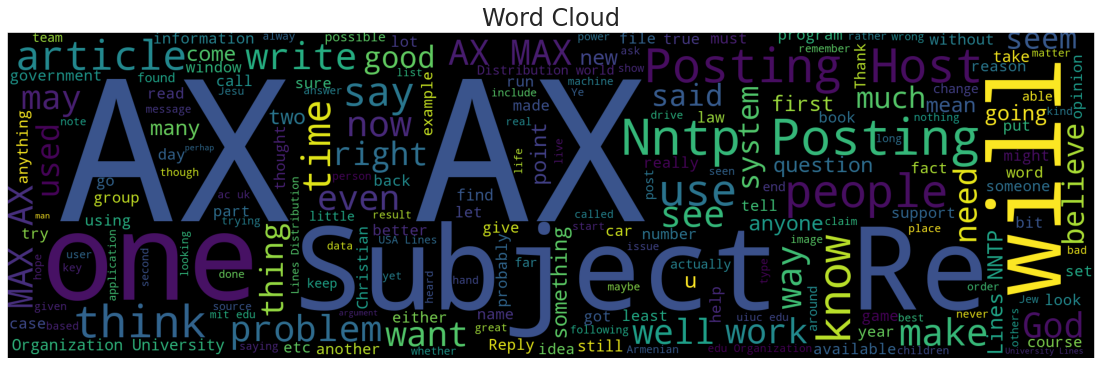

In [4]:
fig, ax = plt.subplots(figsize=(20, 6))
wordcloud = WordCloud(height=600, width=2000, stopwords=STOPWORDS).generate(' '.join((X.values)))
ax.imshow(wordcloud)
ax.set_title('Word Cloud', fontsize=24)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

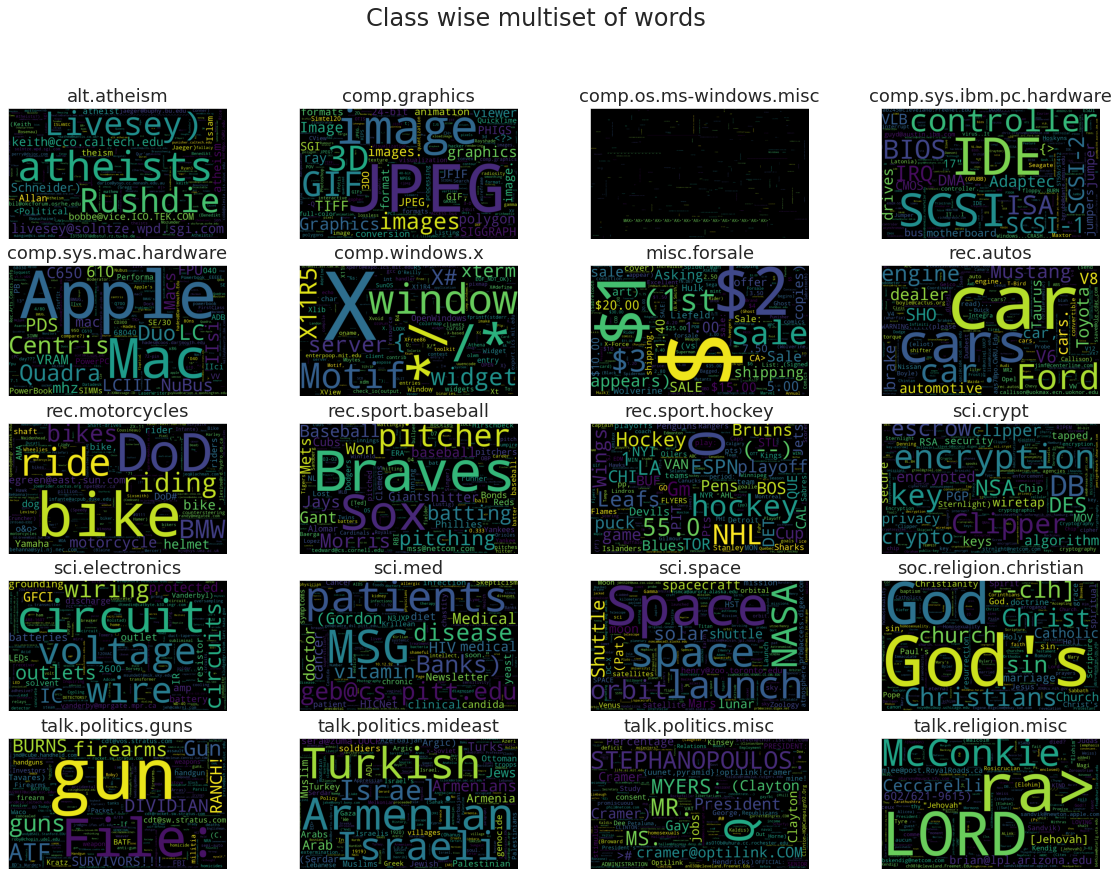

In [5]:
fig, ax = plt.subplots(5, 4, figsize=(20, 14))
fig.suptitle('Class wise multiset of words', fontsize=24)
for i in range(20):
    u = Counter((' '.join((X[y != i].values))).split())
    a = Counter((' '.join((X[y == i].values))).split())
    wordcloud = WordCloud(height=600, width=1000, stopwords=STOPWORDS).generate_from_frequencies((a-u))
    ax[i//4][i%4].imshow(wordcloud)
    ax[i//4][i%4].set_title(f'{dataset["target_names"][i]}', fontsize=18)
    ax[i//4][i%4].xaxis.set_visible(False)
    ax[i//4][i%4].yaxis.set_visible(False)    

# Natural Language Processing

Natural language processing (NLP) is a subfield of linguistics, computer science, and artificial intelligence concerned with the interactions between computers and human language, in particular how to program computers to process and analyze large amounts of natural language data.

Since, text is the most unstructured form of all the available data, various types of noise are present in it and the data is not readily analyzable without any pre-processing. The entire process of cleaning and standardization of text, making it noise-free and ready for analysis is known as text preprocessing.

As it turns out, many Machine Learning algorithms and almost all Deep Learning Architectures are incapable of processing strings or plain text in their raw form. They require numbers as inputs to perform any sort of job, be it classification, regression etc. in broad terms. And with the huge amount of data that is present in the text format, it is imperative to extract knowledge out of it and build applications.

Embeddings are the texts converted into numbers and there may be different numerical representations of the same text. The different types of word embeddings can be broadly classified into two categories-

* Frequency based Embedding
    * Binary Vector
    * Count Vector
    * TF-IDF Vector
* Prediction based Embedding
    * Continuous Bag of Words
    * Skip Gram

Reference: [An Intuitive Understanding of Word Embeddings: From Count Vectors to Word2Vec](https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/)

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import roc_auc_score

skf = StratifiedKFold(shuffle=True, random_state=19)

roc_auc_scores = []
time_taken = []
n_features = []

def train_model():
    model = DecisionTreeClassifier(class_weight='balanced', random_state=19)
    scores = []

    for train_index, test_index in tqdm(skf.split(X, y)):
        X_train, X_test = X_vect[train_index], X_vect[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        scores.append(roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr', average='weighted'))

    feats = X_vect.shape[1]
    score = round(np.mean(scores), 5)*100
        
    return feats, score

## TF-IDF on uncleaned Data

In [7]:
start = time.time()

X_vect = TfidfVectorizer(sublinear_tf=True, ngram_range=(1, 2)).fit_transform(X)
feats, score = train_model()

end = time.time()
t = end - start

n_features.append(feats)
time_taken.append(t)
roc_auc_scores.append(score)

print('Mean score', score)
print('Features used', feats)


Mean score 81.734
Features used 1664476


## Text Cleaning

Any piece of text which is not relevant to the context of the data and the end-output can be specified as the noise.

For example – language stopwords (commonly used words of a language – is, am, the, of, in etc), URLs or links, social media entities (mentions, hashtags), punctuations and industry specific words. This step deals with removal of all types of noisy entities present in the text.

A general approach for text cleaning is to prepare a dictionary of noisy entities, and iterate the text object by tokens (or by words), eliminating those tokens which are present in the noise dictionary.

In [8]:
import re
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

start = time.time()

X = X.progress_apply(lambda text: re.sub(r"\s+", " ", re.sub(r"[^A-Za-z]", " ", text)))
X = X.progress_apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))
X_vect = TfidfVectorizer(sublinear_tf=True, ngram_range=(1, 2)).fit_transform(X)
feats, score = train_model()

end = time.time()
t = end - start

n_features.append(feats)
time_taken.append(t)
roc_auc_scores.append(score)

print('Mean score', score)
print('Features used', feats)


Mean score 82.293
Features used 1644582


## Text Normalization

Another type of textual noise is about the multiple representations exhibited by single word.

For example – “play”, “player”, “played”, “plays” and “playing” are the different variations of the word – “play”, Though they mean different but contextually all are similar. The step converts all the disparities of a word into their normalized form (also known as lemma). Normalization is a pivotal step for feature engineering with text as it converts the high dimensional features (N different features) to the low dimensional space (1 feature), which is an ideal ask for any ML model.

The most common lexicon normalization practices are :

* Stemming:  Stemming is a rudimentary rule-based process of stripping the suffixes (“ing”, “ly”, “es”, “s” etc) from a word.
* Lemmatization: Lemmatization, on the other hand, is an organized & step by step procedure of obtaining the root form of the word, it makes use of vocabulary (dictionary importance of words) and morphological analysis (word structure and grammar relations).

In [9]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

start = time.time()

X = X.progress_apply(lambda x: ' '.join(wordnet_lemmatizer.lemmatize(word).lower() for word in x.split()))
X_vect = TfidfVectorizer(sublinear_tf=True, ngram_range=(1, 2)).fit_transform(X)
feats, score = train_model()

end = time.time()
t = end - start

n_features.append(feats)
time_taken.append(t)
roc_auc_scores.append(score)

print('Mean score', score)
print('Features used', feats)


Mean score 82.435
Features used 1588593


## Feature Selection

Feature Selection is one of the core concepts in machine learning which hugely impacts the performance of your model. The data features that you use to train your machine learning models have a huge influence on the performance you can achieve.

Irrelevant or partially relevant features can negatively impact model performance.
Having irrelevant features in your data can decrease the accuracy of the models and make your model learn based on irrelevant features.

Feature Selection is the process where you automatically or manually select those features which contribute most to your prediction variable or output in which you are interested in.


In [10]:
class RemoveIrrelevantFeatures():

    def __init__(self, problem_type, random_state=None):
        self.problem_type = problem_type
        self.random_state = random_state
        if problem_type not in ['regression', 'classification']:
            raise Exception('Invalid problem type')
        
    def fit(self, X, y):
        if self.problem_type == 'regression':
            model = DecisionTreeRegressor(random_state=self.random_state)
        else:
            model = DecisionTreeClassifier(class_weight='balanced', random_state=self.random_state)
        model.fit(X, y)
        self.support = (model.feature_importances_ > 0)
        self.indices = np.where(self.support)[0]
        
    def transform(self, X, y=None):
        return X[:, self.indices]
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X, y)
    
    def get_support(self):
        return self.support

In [11]:
start = time.time()

pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(sublinear_tf=True, ngram_range=(1, 2))),
    ('feature_selector', RemoveIrrelevantFeatures(problem_type='classification', random_state=19)),
])
X_vect = pipeline.fit_transform(X, y)
feats, score = train_model()

end = time.time()
t = end - start

n_features.append(feats)
time_taken.append(t)
roc_auc_scores.append(score)

print('Mean score', score)
print('Features used', feats)


Mean score 82.428
Features used 2545


# Performance Comparison

In [12]:
for i in range(3):
    n_features[i] -= n_features[i+1]

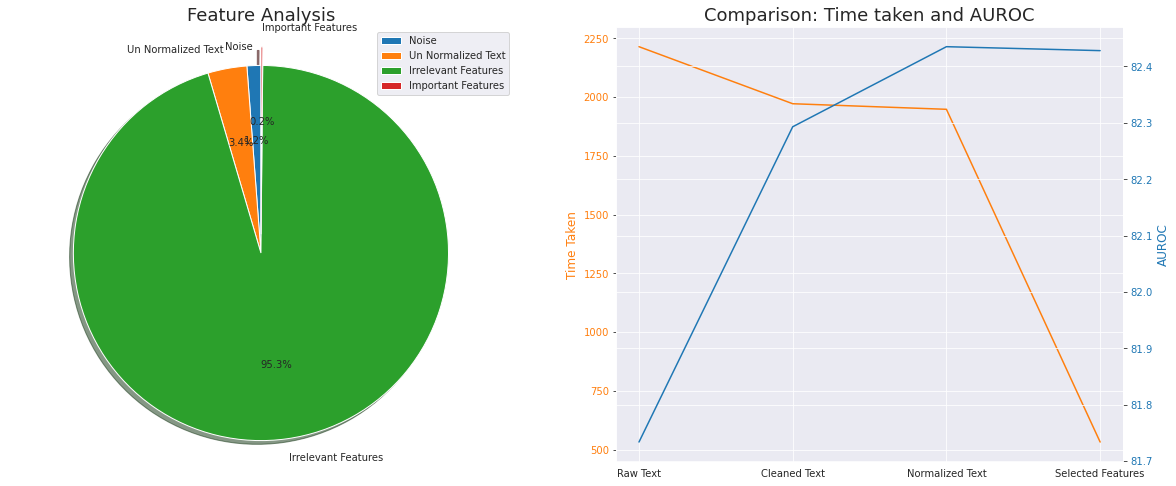

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax = ax.tolist()
labels = ['Noise', 'Un Normalized Text', 'Irrelevant Features', 'Important Features']
explode = (0, 0, 0, 0.1)
ax[0].pie(n_features, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax[0].set_title('Feature Analysis', fontsize=18)
ax[0].axis('equal')
ax[0].legend()


t = ['Raw Text', 'Cleaned Text', 'Normalized Text', 'Selected Features']

color = 'tab:orange'
ax[1].set_ylabel('Time Taken', color=color, fontsize=12)
ax[1].plot(t, time_taken, color=color)
ax[1].tick_params(axis='y', labelcolor=color)

ax.append(ax[1].twinx())

color = 'tab:blue'
ax[2].set_ylabel('AUROC', color=color, fontsize=12)
ax[2].plot(t, roc_auc_scores, color=color)
ax[2].tick_params(axis='y', labelcolor=color)

ax[1].set_title('Comparison: Time taken and AUROC', fontsize=18)
plt.show()

* Cleaning and Normalization reduce the time taken as well as improve the model's capability of distinguishing between classes
* Feature Selection reduces the time taken by a huge margin but also there is very slight decrease in AUROC
* For this case, as the pie chart depicts:
    * 2% features are actually noise
    * 3.4% features are due to Un normalised data
    * 95.3% features are irrelevant
    * Only 0.2% features are relevant
    